In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline 
#%matplotlib widget 

In [166]:
def parse_file(path):
    
    with open(path+"/job.log.0", "r", encoding="utf-8") as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    
    
    rouge_indices = [i for i, s in enumerate(content) if 'ROUGE-F' in s]
    r_scores= np.array([(content[i][content[i].find(": ")+2:]).split('/') for i in rouge_indices])
    
    indices = [i for i, s in enumerate(content) if 'word_embedding_name' in s]
    indices_2 = [i for i, s in enumerate(content) if 'Num train examples' in s]
    params=content[:indices[0]+1]+ [i[31:] for i in content[indices_2[0]:indices_2[0]+3]] + ["ROUGE-F(1/2/l) on validation set: "+'/'.join(r_scores[-1])]
    params= dict([p.split(":") for p in params])
    params['epochs'] = np.ceil(int(params['Max train steps'])/1490).astype(int)
    if path[11:]=="":
        params['name']="Current run"
    else:
        params['name']=path[11:]
        
    indices = [i for i, s in enumerate(content) if 'loss:' in s]
    loss_per_step =np.array([float(content[i][content[i].find("loss:")+6:content[i].find(", ppl")]) for i in indices])
    ppl_per_step=np.array([float(content[i][content[i].find("ppl:")+5:content[i].find(", acc")]) for i in indices])
    acc_per_step=np.array([float(content[i][content[i].find("acc:")+5:content[i].find(", lea")]) for i in indices])
    lr_per_step=np.array([float(content[i][content[i].find("rate:")+6:content[i].find(", spe")]) for i in indices])
    epochs=np.array([int(content[i][content[i].find("epoch:")+7:content[i].find(", pro")]) for i in indices])
    epochs_indexs=[np.where(epochs==i) for i in np.unique(epochs)]
    acc_mean_per_epoch=[np.mean(acc_per_step[ep]) for ep in epochs_indexs]
    loss_mean_per_epoch=[np.mean(loss_per_step[ep]) for ep in epochs_indexs]
    ppl_mean_per_epoch=[np.mean(ppl_per_step[ep]) for ep in epochs_indexs]
    lr_mean_per_epoch=[np.mean(lr_per_step[ep]) for ep in epochs_indexs]
    
    
    
    
    values=[i for i in params.values()]
    keys=[i for i in params.keys()]
    
    
    return values, keys ,content,epochs_indexs, loss_per_step, ppl_per_step,lr_per_step, acc_mean_per_epoch, loss_mean_per_epoch, ppl_mean_per_epoch, lr_mean_per_epoch, r_scores 

def plot_curves(logarithmic=True, start_step=0):
    title=['loss_per_step', 'ppl_per_step','lr_per_step', 'acc_mean_per_epoch', 'loss_mean_per_epoch', 'ppl_mean_per_epoch', 'lr_mean_per_epoch']
    for i in range(4,11):
        plt.figure(figsize=(20,10))
        plt.title(title[i-4])
        for r in res:
            plt.plot(r[i][start_step:], label=r[0][-1])
        plt.legend()
        if logarithmic:   
            plt.yscale('log')
            plt.ylabel("Logarithmic value")
        else:
            plt.ylabel("Value")
        if i < 7:
            plt.xlabel("Step")
        else:
            plt.xlabel("Epoch")
        plt.grid()
        plt.show()


In [161]:
def plot_rouge(res):
    fig = plt.figure(figsize=(10,5))
    plt.title("Rouge comparisson")
    times=0
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, val in enumerate(res):
        list_rouge=[[float(va[0]),float(va[1]),float(va[2])]for va in val[-1]]
        aux_list=[l[0] for l in list_rouge]
        if len(aux_list) > times:
            times= len(aux_list)
        plt.plot(aux_list,  color=cycle[i], label="Rouge 1: "+val[0][-1])
        plt.plot([l[1] for l in list_rouge], color=cycle[i], linestyle='--', label="Rouge 2")
        plt.plot([l[2] for l in list_rouge], color=cycle[i], linestyle='-.', label="Rouge L")

    plt.xticks(np.arange(0,times),np.arange(1,times+1)*10 )
    plt.ylabel("Rouge value")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid()
    plt.show()
    fig.savefig('./imgs/rouge.pdf', dpi=fig.dpi)

In [162]:
paths=['./logs/log/10-March-10-epoch-paragraph-small-test','./logs/log/14-March-100-epoch-sentence-pruned-70-30']

In [167]:
res=[parse_file(path) for path in paths]

In [168]:
df=pd.DataFrame([i[0] for i in res], columns=res[0][1])

In [169]:
pd.set_option('display.max_columns', None)
display(df)

,attention_probs_dropout_prob,dec_graph_layers,dec_word_pos_embedding_name,enc_graph_layers,enc_sen_pos_embedding_name,enc_word_layers,enc_word_pos_embedding_name,hidden_act,hidden_dropout_prob,hidden_size,initializer_range,max_position_embeddings,num_attention_heads,postprocess_command,preprocess_command,word_embedding_name,Num train examples,Max train steps,Num warmup steps,ROUGE-F(1/2/l) on validation set,epochs,name
0,0.1,8,dec_word_pos_embedding,2,enc_sen_pos_embedding,6,enc_word_pos_embedding,relu,0.1,256,0.02,512,8,da,n,word_embedding,44692,11459,8000,33.83/10.55/30.11,8,10-March-10-epoch-paragraph-small-test
1,0.1,8,dec_word_pos_embedding,2,enc_sen_pos_embedding,6,enc_word_pos_embedding,relu,0.1,256,0.02,512,8,da,n,word_embedding,44692,148973,8000,43.58/15.63/39.99,100,14-March-100-epoch-sentence-pruned-70-30


Metric curves in logarithmic scale

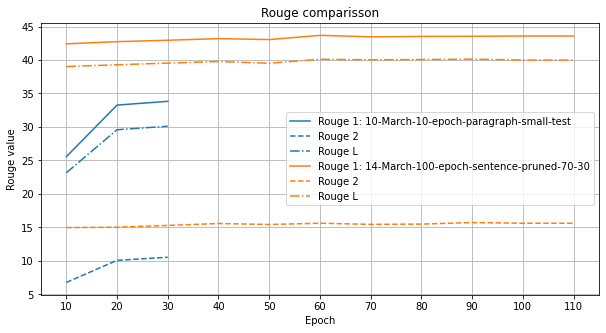

In [153]:
plot_rouge(res)

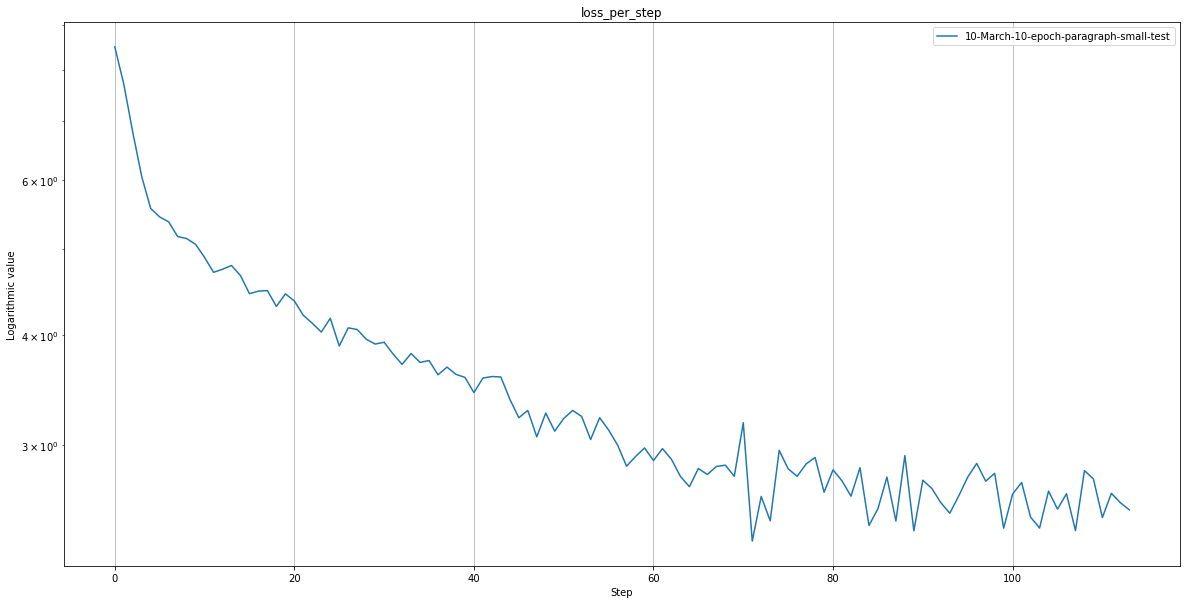

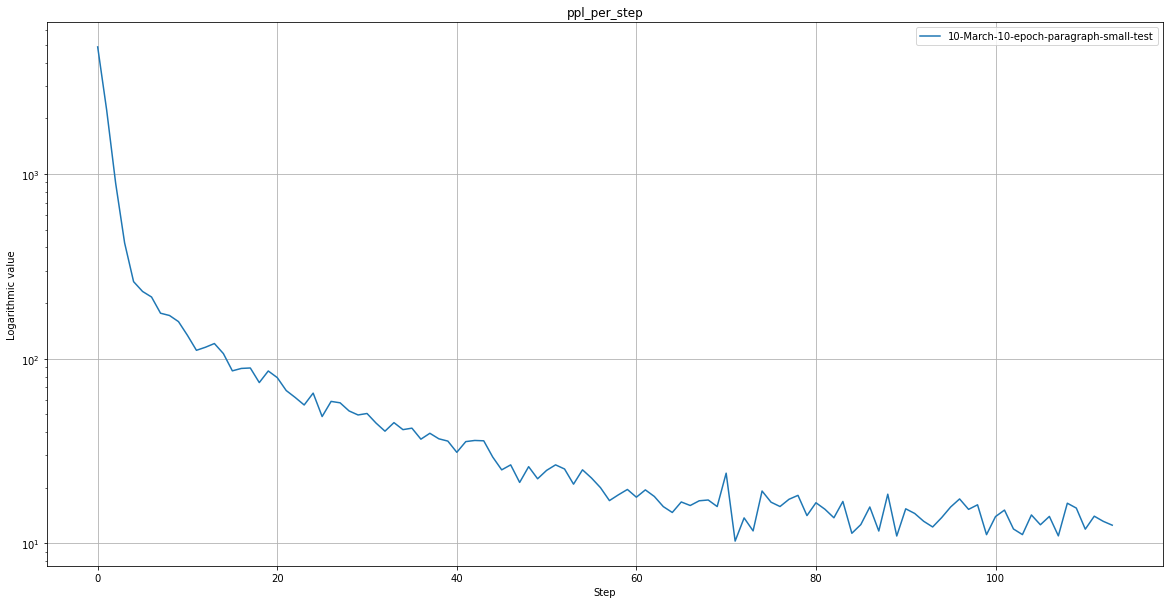

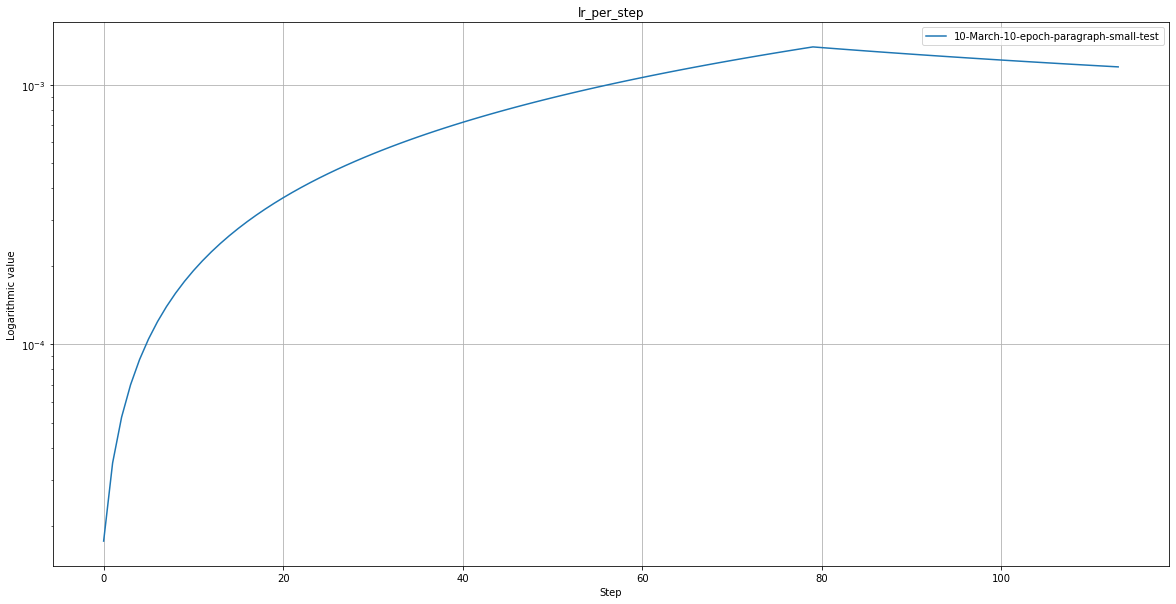

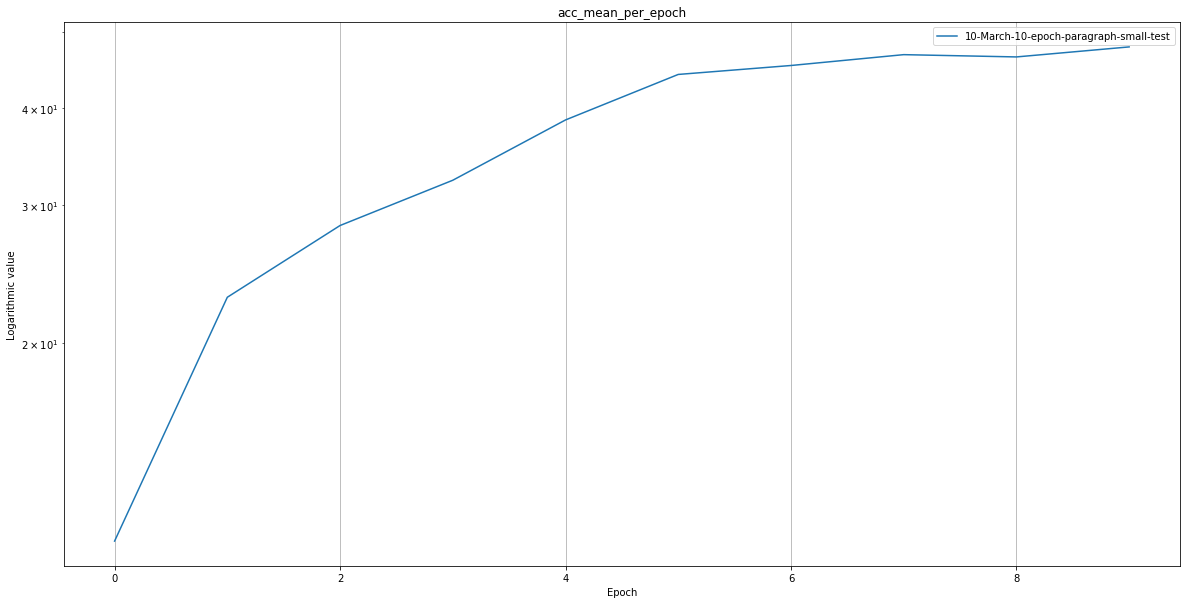

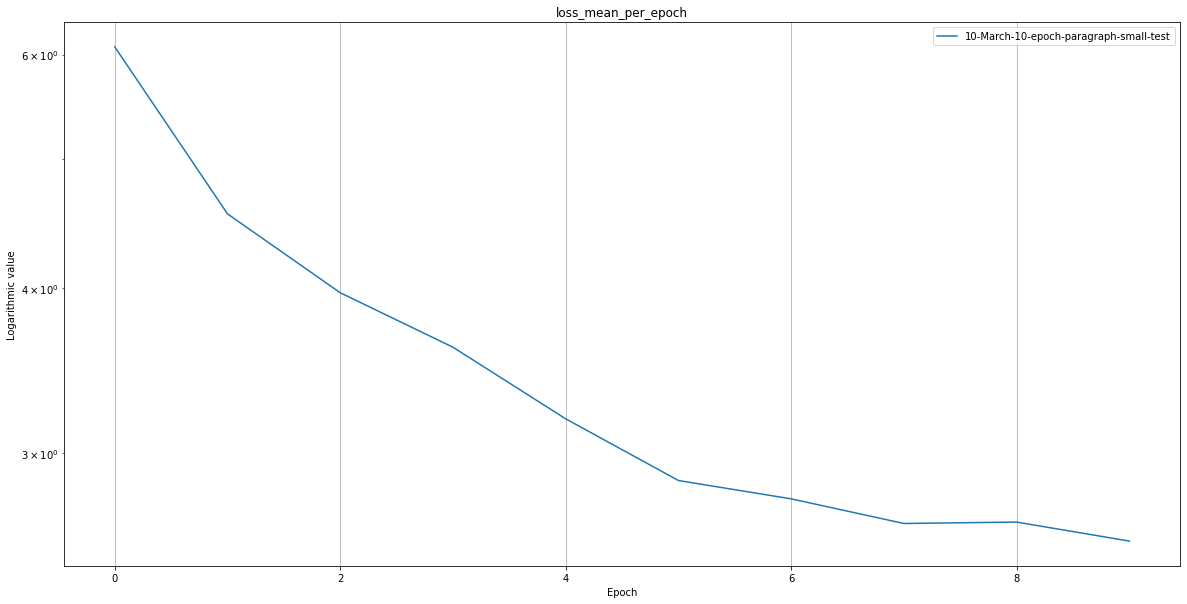

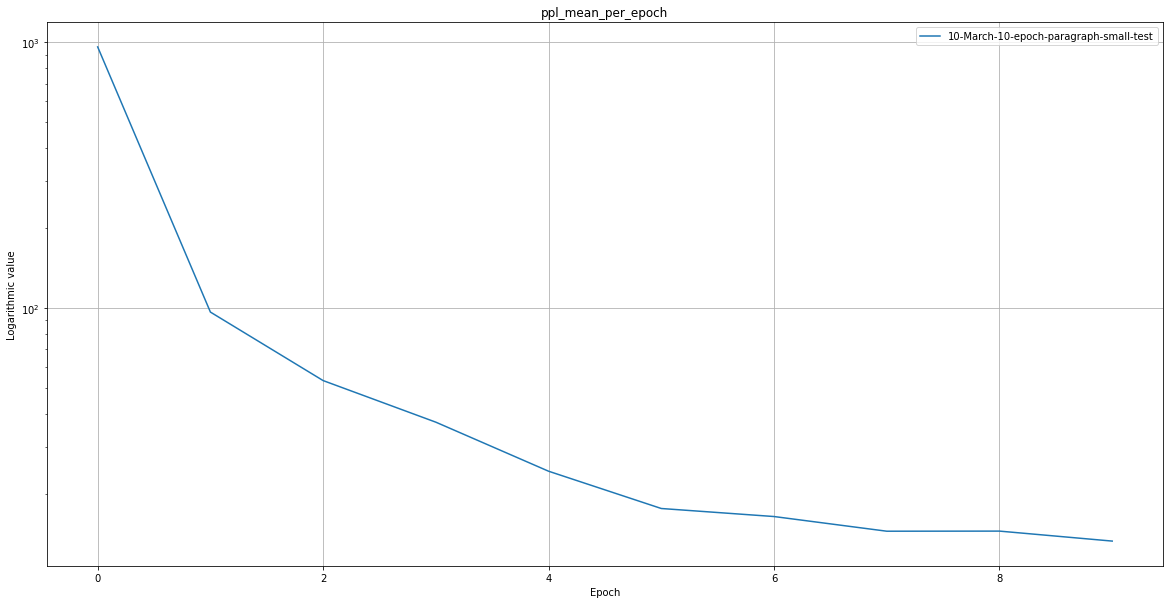

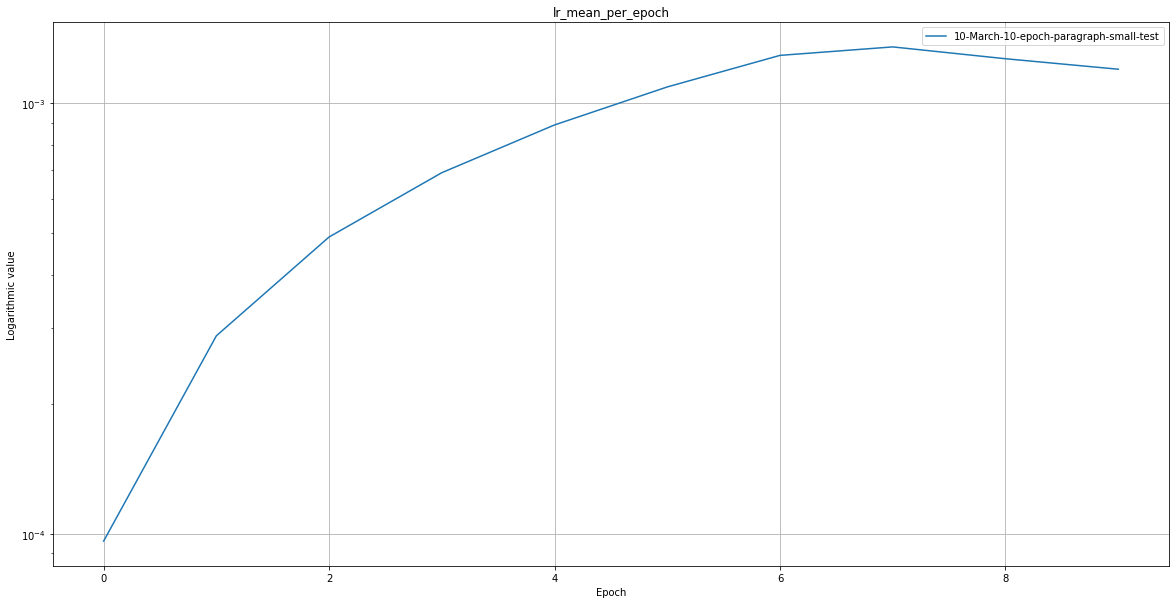

In [13]:
plot_curves(logarithmic=True)

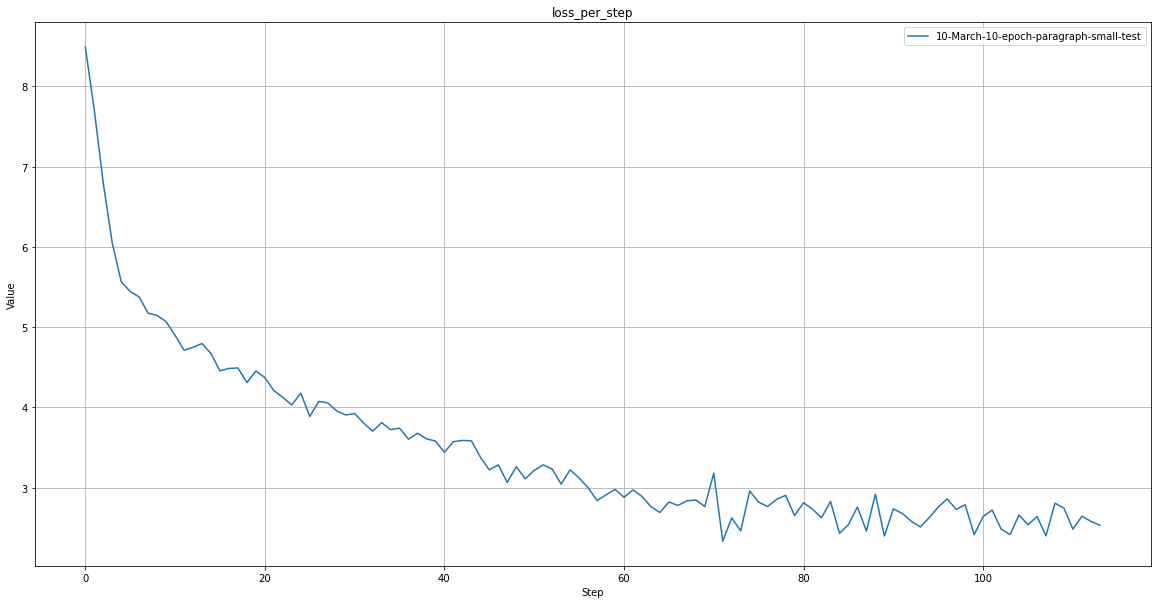

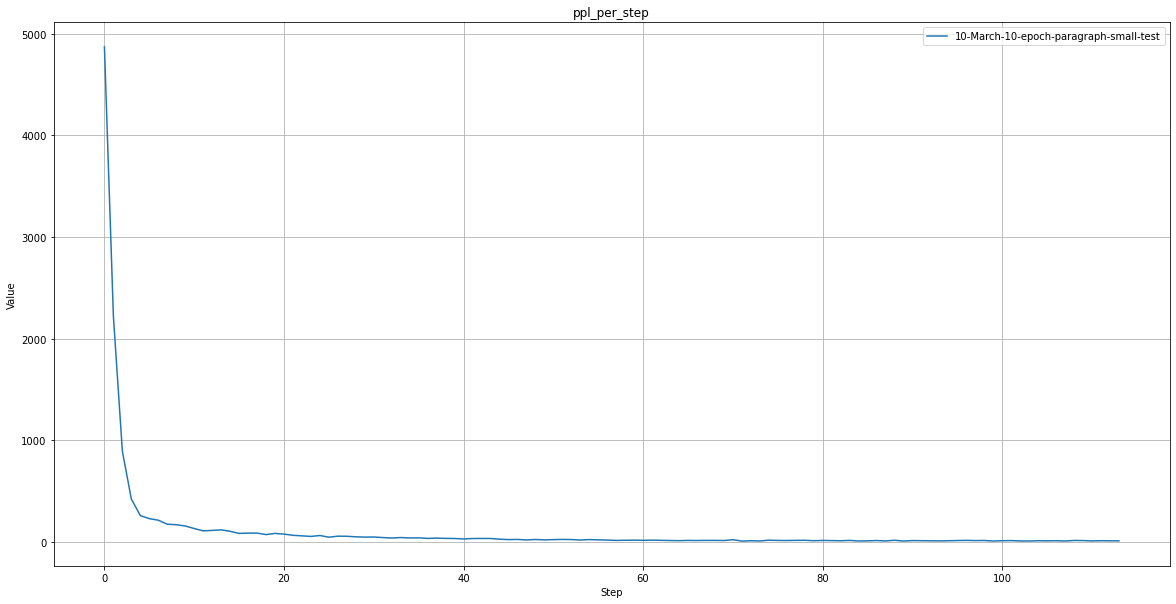

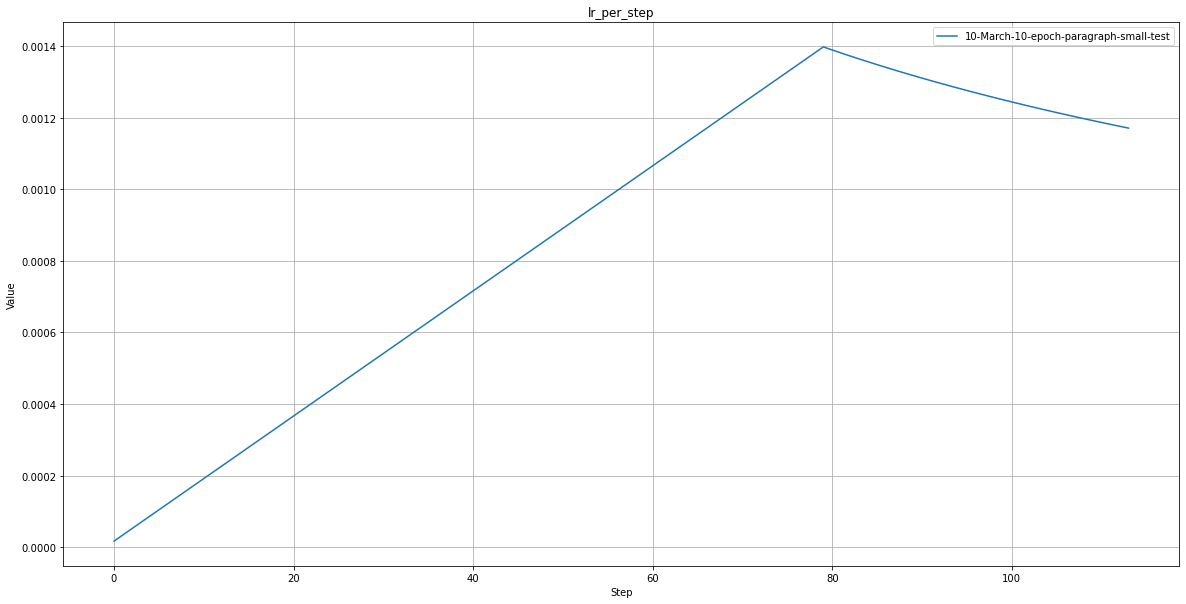

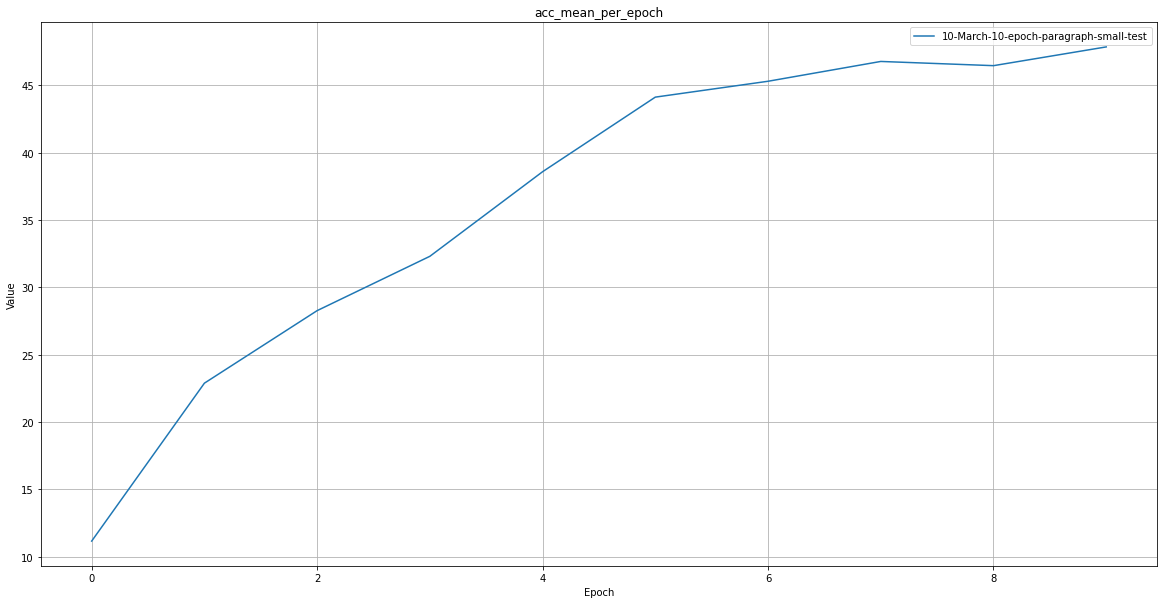

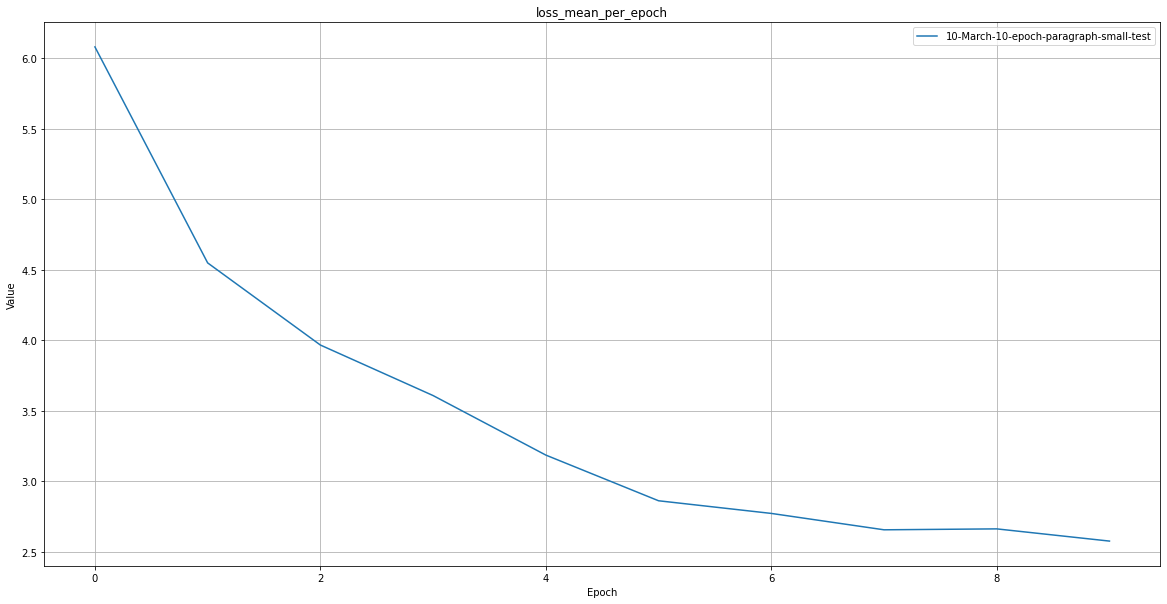

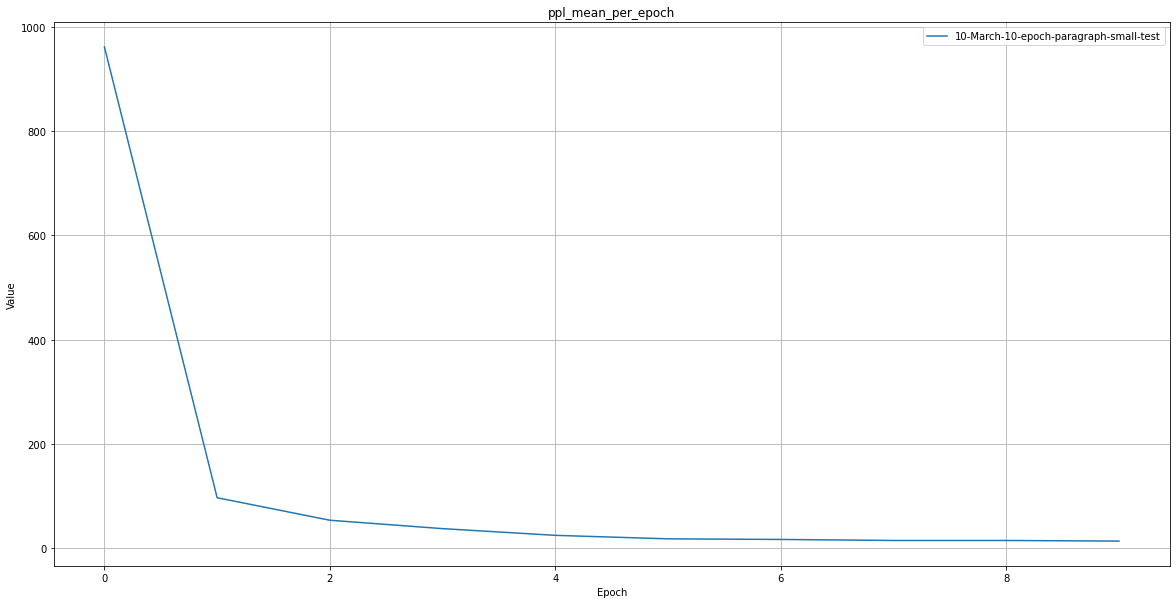

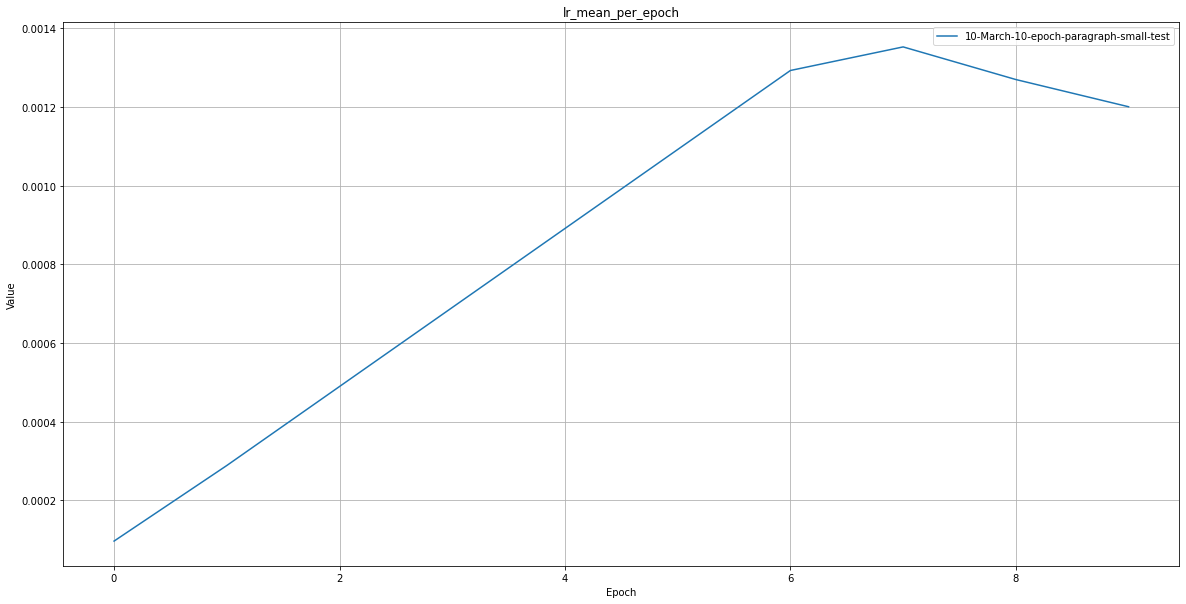

In [14]:
plot_curves(logarithmic=False)